# IV Tools – Pulsed-Field Nonlinear Transport Processing

This notebook demonstrates the use of **IV Tools**, part of the *High Magnetic Field Science Toolset* (LANL, Copyright No. C20099),
for processing non-linear transport data acquired in pulsed magnetic fields.

---

## Purpose

This notebook provides a streamlined workflow for converting raw TDMS data from NHMFL pulsed-field experiments into:
- segmented IV curves,
- background-corrected voltage–current characteristics,
- power-law fits and extracted critical currents,
- saved analysis outputs suitable for downstream plotting or aggregation.


---

## Data assumptions

This notebook assumes:
- Data are acquired using the **MAGLAB LabActor Framework**
- Raw data are stored as **TDMS** files
- Current and voltage are measured through calibrated gain chains
- Magnetic field information is provided either by:
  - PPMS metadata, or
  - an external pulsed-field trace

No manual IV segmentation is required.

---

## Software provenance

- IV Tools repository:  
  https://github.com/stef-ma/ivtools  

- High Magnetic Field Science Toolset:  
  https://github.com/ffb-LANL/High-Magnetic-Field-Science-Toolset  

LabActor is based on the National Instruments Actor Framework architecture.

---

## Processing pipeline

1. Load a TDMS file into an `IV_File` object  
2. Automatically segment the time stream into individual IV sweeps  
3. Correct linear backgrounds and suppress noise  
4. Fit non-linear regions using power-law models  
5. Save processed IV data and fit results to disk  

---

## Data flow overview

Raw TDMS data stream:
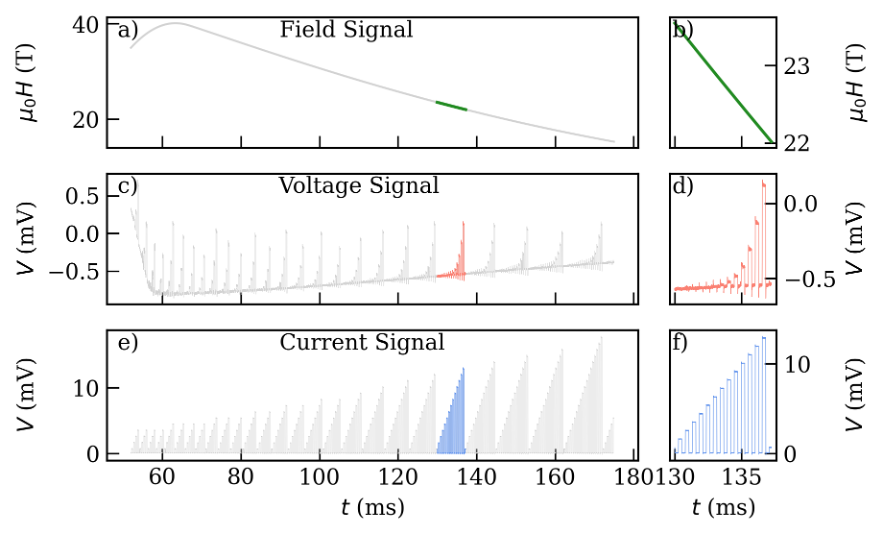

Automatic IV segmentation:
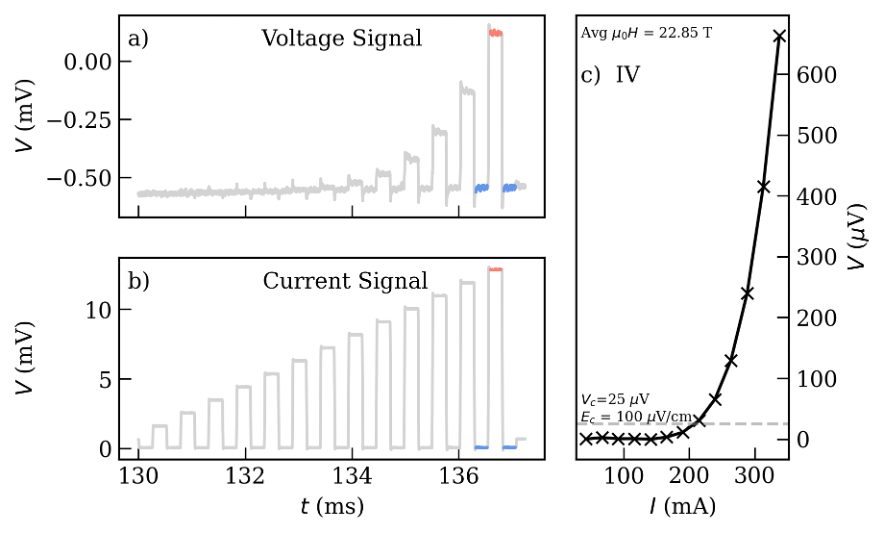

Background correction and fitting:
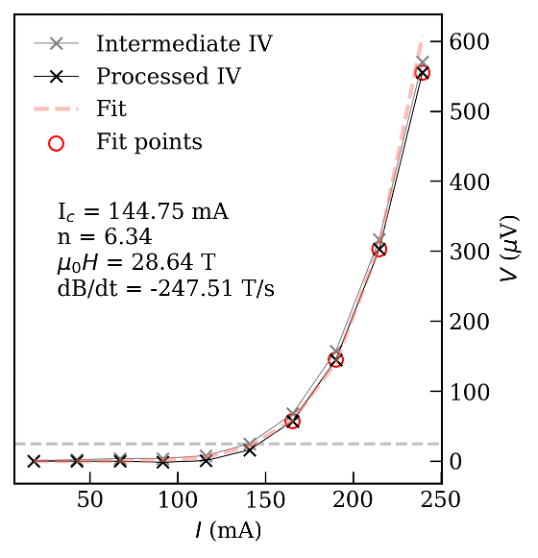

---

**Next:**  
Proceed to the next cell to define experimental parameters and load a TDMS file.


In [1]:
# presets
import matplotlib as mpl

mpl.rcParams.update({
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 6,        # Length of the major ticks
    'ytick.major.size': 6,
    'xtick.minor.visible': False, # Hide minor ticks
    'ytick.minor.visible': False,
    'axes.linewidth': 1,          # Line width of axes
    'font.family': 'serif',     # Set font
    'font.size': 11,              # Font size
})

# /Users/smarinkovic/DATA/01.Projects/03.Archiving/Vortex/UKAEA/October_2025/102325/p120434_102325.tdms

# /Users/smarinkovic/DATA/0.Misc/p029_171756_012026.tdms

In [2]:
import ivtools as ivt
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# -----------------------------
# Widget definitions
# -----------------------------

filepath_w = widgets.Textarea(
    description="TDMS file",
    # placeholder="/path/to/file.tdms",
    value = '/Users/smarinkovic/DATA/0.Misc/p020_135918_012226.tdms',
    layout=widgets.Layout(width="80%", height="60px")
)

resistor_w = widgets.FloatText(description="Resistor (Ω)", value=1.0)
temperature_w = widgets.FloatText(description="Temperature (K)", value=77)
voltage_gain_w = widgets.FloatText(description="Voltage gain", value=1.0)
current_gain_w = widgets.FloatText(description="Current gain", value=1.0)

vchan_w = widgets.Text(description="V channel", value='V')
ichan_w = widgets.Text(description="I channel", value='I')

magnet_w = widgets.Text(description="Magnet", placeholder="e.g. Mid-Pulse or PPMS")
tfield_w = widgets.FloatText(description="PPMS field (T)", value=0.0)

load_button = widgets.Button(description="Load IV file", button_style="primary")

t_range_w = widgets.FloatRangeSlider(
    description="Time window (s)",
    disabled=True,
    layout=widgets.Layout(width="80%"),
    continuous_update=False
)

output = widgets.Output()

# -----------------------------
# Plotting helper
# -----------------------------

def plot_raw_signals(ivf, tmin, tmax):
    mask = (ivf.t >= tmin) & (ivf.t <= tmax)

    with output:
        plt.close(plt.gcf())
        clear_output(wait=True)

        fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

        axs[0].plot(ivf.t[mask]*1e3, ivf.B[mask], lw= .5, color = 'black')
        axs[0].set_ylabel("B (T)")
        axs[0].set_title("Raw signals")

        axs[1].plot(ivf.t[mask]*1e3, ivf.I[mask]*1e3, lw= .1, color = 'black')
        axs[1].set_ylabel("I (mA)")
        twax = axs[1].twinx()
        twax.plot(ivf.t[mask]*1e3, ivf.I[mask]*resistor_w.value*1e6, lw= .1, color = 'black')
        twax.set_ylabel("I signal ($\mu$V)")
        

        axs[2].plot(ivf.t[mask]*1e3, ivf.V[mask]*1e6, lw= .1, color = 'black')
        axs[2].set_ylabel("V ($\mu$V)")
        axs[2].set_xlabel("Time (ms)")

        for ax in axs:
            ax.grid(alpha=.5)

        fig.align_labels()
        plt.tight_layout()
        plt.show()
        # display(fig)
        # plt.close(fig)


# -----------------------------
# Callbacks
# -----------------------------

def load_ivf(_):
    global ivf,fp,temp

    fp = filepath_w.value
    temp = temperature_w.value

    ivf = ivt.IV_File(
        filepath_w.value,
        resistor_w.value,
        temperature_w.value,
        voltage_gain_w.value,
        current_gain_w.value,
        voltage_channel=vchan_w.value,
        current_channel=ichan_w.value,
        ppms_field=tfield_w.value if magnet_w.value == "PPMS" else None
    )

    if not ivf.passed:
        print("IV_File failed to load.")
        return

    # Initialize slider from data range
    tmin, tmax = ivf.t.min(), ivf.t.max()

    t_range_w.min = tmin
    t_range_w.max = tmax
    t_range_w.value = (tmin, tmax)
    t_range_w.step = (tmax - tmin) / 1000
    t_range_w.disabled = False

    plot_raw_signals(ivf, tmin, tmax)

    print("IV_File loaded and stored as `ivf` in workspace.")

def update_plot(change):
    if "ivf" not in globals():
        return

    tmin, tmax = change["new"]
    plot_raw_signals(ivf, tmin, tmax)


load_button.on_click(load_ivf)
t_range_w.observe(update_plot, names="value")

# -----------------------------
# Display layout
# -----------------------------

display(
    widgets.VBox([
        filepath_w,
        widgets.HBox([resistor_w, temperature_w]),
        widgets.HBox([voltage_gain_w, current_gain_w]),
        widgets.HBox([vchan_w, ichan_w]),
        widgets.HBox([magnet_w, tfield_w]),
        load_button,
        t_range_w,
        output
    ])
)


In [3]:
# import nptdms
# ivf = nptdms.TdmsFile.read('/Users/smarinkovic/DATA/0.Misc/p020_135918_012226.tdms')


# for grp in ivf.groups():
#     for chan in grp.channels():
#         config = chan.properties
#         print('\n\nChannel:',chan)
#         for key in chan.properties:
#             if 'wf' in key or 'delay' in key or 'Configuration' in key:
#                 if 'Configuration' not in key:
#                     print(key,chan.properties[key])
#                 else:
#                     for configline in chan.properties[key].splitlines():
#                         if 'delay' in configline:
#                             print(configline)
#         try:
#             chan.time_track()
#             print('+++Can make time track!+++')
#         except:
#             print('XXXCan not make time track!XXX')
#         # lbl = str(chan)
#         # y = chan.data
#         # x = chan.time_track()
#         # plt.plot(x,y)
#         # plt.title(lbl)
#         # plt.grid()
#         # plt.gca().set_xlim(0.025,0.075)
#         # plt.show()

In [4]:

# for grp in ivf.tdms_file.groups():
#     for chan in grp.channels():
#         config = ivf._parse_config(chan)
#         lbl = str(chan)
#         y = chan.data
#         x = chan.time_track()

#         for key in chan.properties:
#             print(key,chan.properties[key])
#         plt.plot(x,y)
#         plt.title(lbl)
#         plt.grid()
#         plt.gca().set_xlim(0.025,0.075)
#         plt.show()


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# -----------------------------
# Processing parameter widgets
# -----------------------------

sample_w = widgets.Text(description="Sample", value="SampleA")
angle_w = widgets.FloatText(description="Angle (deg)", value=0.0)

voltage_criterion_w = widgets.FloatText(description="Vc (V)", value=1e-6)
noise_level_w = widgets.FloatText(description="Noise (V)", value=5e-7)

linear_sub_level_w = widgets.FloatSlider(
    description="Linearity criterion in |n-1|",
    min=0.0,
    max=1.0,
    step=0.01,
    value=0.95,
    readout_format=".2f",
    continuous_update=False,
    layout=widgets.Layout(width="100%"),
    style={"description_width": "175px"},
)
# linear_sub_criterion_w = widgets.FloatText(
#     description="Lin. background R$^2$ minimum", value=0.9
# )
linear_sub_criterion_w = widgets.FloatSlider(
    description="Background sub strictness",
    min=0.0,
    max=1.0,
    step=0.01,
    value=0.95,
    readout_format=".2f",
    continuous_update=False,
    layout=widgets.Layout(width="100%"),
    style={"description_width": "175px"},

)
# linear_sub_level_w = widgets.FloatText(
#     description="Linearity n-value criterion", value=0.25
# )
power_law_criterion_w = widgets.FloatSlider(
    description="Power-law strictness",
    min=0.0,
    max=1.0,
    step=0.01,
    value=0.95,
    readout_format=".2f",
    continuous_update=False,
    layout=widgets.Layout(width="100%"),
    style={"description_width": "175px"},
)

minfp_w = widgets.IntText(description="min pts", value=5)
maxfp_w = widgets.IntText(description="max pts", value=200)

verbose_w = widgets.Checkbox(description="Verbose", value=False)

process_button = widgets.Button(
    description="Process IVs",
    button_style="danger"
)

# -----------------------------
# Plot control widgets
# -----------------------------

t_slider = widgets.FloatRangeSlider(
    description="t-range [s]",
    disabled=True,
    continuous_update=False,
    layout=widgets.Layout(width="80%")
)

show_raw_cb = widgets.Checkbox(value=True, description="Raw V")
show_proc_cb = widgets.Checkbox(value=True, description="Processed V")
show_fit_cb = widgets.Checkbox(value=True, description="Fit")

output_proc = widgets.Output()

# -----------------------------
# Plotting function (NO duplication)
# -----------------------------

def plot_processed_iv(tlims, show_raw, show_proc, show_fit):
    tmin, tmax = tlims

    with output_proc:
        clear_output(wait=True)

        fig = plt.figure(dpi=300, figsize=(12, 8))
        gs = fig.add_gridspec(2, 2, hspace=.05, wspace=.25)

        ax1 = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
        twax1 = ax1.twinx()
        twax2 = ax2.twinx()

        icax = fig.add_subplot(gs[0, 1])
        nax = fig.add_subplot(gs[1, 1])

        # --- raw time window ---
        idx = (ivf.t >= tmin) & (ivf.t <= tmax)

        ax1.plot(ivf.t[idx] * 1e3, ivf.V[idx] * 1e3,
                 lw=0.3, color="salmon")
        twax1.plot(ivf.t[idx] * 1e3, ivf.B[idx],
                   lw=1.5, color="forestgreen")

        ax1.set_ylabel("V [mV]")
        twax1.set_ylabel("B [T]")

        # --- IV curves ---
        for iv_idx in ivs['IV_Index'].dropna().unique():
            split = ivs[ivs['IV_Index'] == iv_idx]

            tarr = split['Time [s]'].to_numpy()
            mask = (tarr >= tmin) & (tarr <= tmax)
            if not mask.any():
                continue

            tms = tarr[mask] * 1e3
            volts = split['Voltage [V]'].to_numpy()[mask] * 1e3
            proc_v = split['Processed Voltage [V]'].to_numpy()[mask] * 1e3
            amps = split['Current [A]'].to_numpy()[mask] * 1e3

            if show_raw:
                ax2.plot(tms, volts, marker='x', lw=.25, alpha=.5, color="salmon")

            if show_proc:
                ax2.plot(tms, proc_v, marker='x', lw=.5, alpha=.5, color="purple")

            twax2.plot(tms, amps, lw=0.5,
                       color="cornflowerblue", alpha=0.5)

            fit = fits[fits['IV_Index'] == iv_idx]
            if show_fit and not fit.empty:
                k = float(fit['k'].iloc[0])
                n = float(fit['n'].iloc[0])
                fit_y = ivt.powerlaw(amps / 1e3, k, n) * 1e3
                ax2.plot(tms, fit_y, ls="--")

                icax.scatter(fit['Avg Field [T]'], fit['I_c'] * 1e3)
                nax.scatter(fit['Avg Field [T]'], fit['n'])

        ax2.set_xlabel("t [ms]")
        ax2.set_ylabel("V [mV]")
        twax2.set_ylabel("I [mA]", color='cornflowerblue')

        nax.set_xlabel("$\mu_0 H$ [T]")

        icax.set_ylabel("I$_c$ [mA]")
        nax.set_ylabel("n")

        for ax in [ax1, ax2, icax, nax]:
            ax.grid(alpha=.4)

        for ax in [ax1, icax]:
            ax.set_xticklabels([])

        for ax in [icax, nax]:
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position('right')

        plt.tight_layout()
        plt.show()
        plt.close(fig)
        # display(fig)

# -----------------------------
# Callbacks
# -----------------------------

def run_processing(_):
    global ivs, fits, ivf

    if "ivf" not in globals():
        with output_proc:
            clear_output()
            print("No IV_File loaded.")
        return

    ivs, fits, ivf = ivt.process_ivf(
        ivf,
        filepath_w.value,
        sample_w.value,
        temperature_w.value,
        angle_w.value,
        tfield_w.value,
        voltage_criterion_w.value,
        noise_level_w.value,
        linear_sub_criterion_w.value,
        power_law_criterion_w.value,
        minfp_w.value,
        maxfp_w.value,
        magnet=magnet_w.value,
        verbose=verbose_w.value,
        lin_sub_level = linear_sub_level_w.value
    )

    # initialize time slider
    t_slider.min = ivf.t.min()
    t_slider.max = ivf.t.max()
    t_slider.value = (ivf.t.min(), ivf.t.min() + 0.05)
    t_slider.step = (t_slider.max - t_slider.min) / 1000
    t_slider.disabled = False

    plot_processed_iv(t_slider.value,
                      show_raw_cb.value,
                      show_proc_cb.value,
                      show_fit_cb.value)

def update_plot(change):
    if "ivs" not in globals():
        return

    plot_processed_iv(
        t_slider.value,
        show_raw_cb.value,
        show_proc_cb.value,
        show_fit_cb.value
    )

process_button.on_click(run_processing)

t_slider.observe(update_plot, names="value")
show_raw_cb.observe(update_plot, names="value")
show_proc_cb.observe(update_plot, names="value")
show_fit_cb.observe(update_plot, names="value")

# -----------------------------
# Display layout
# -----------------------------

display(
    widgets.VBox([
        widgets.HTML("<b>IV Processing Parameters</b>"),
        widgets.HBox([sample_w, angle_w]),
        widgets.HBox([voltage_criterion_w]),
        widgets.HBox([noise_level_w]),
        widgets.HBox([linear_sub_criterion_w]),
        widgets.HBox([linear_sub_level_w]),
        widgets.HBox([power_law_criterion_w]),
        widgets.HBox([minfp_w, maxfp_w]),
        verbose_w,
        process_button,
        widgets.HTML("<hr>"),
        t_slider,
        widgets.HBox([show_raw_cb, show_proc_cb, show_fit_cb]),
        output_proc
    ])
)


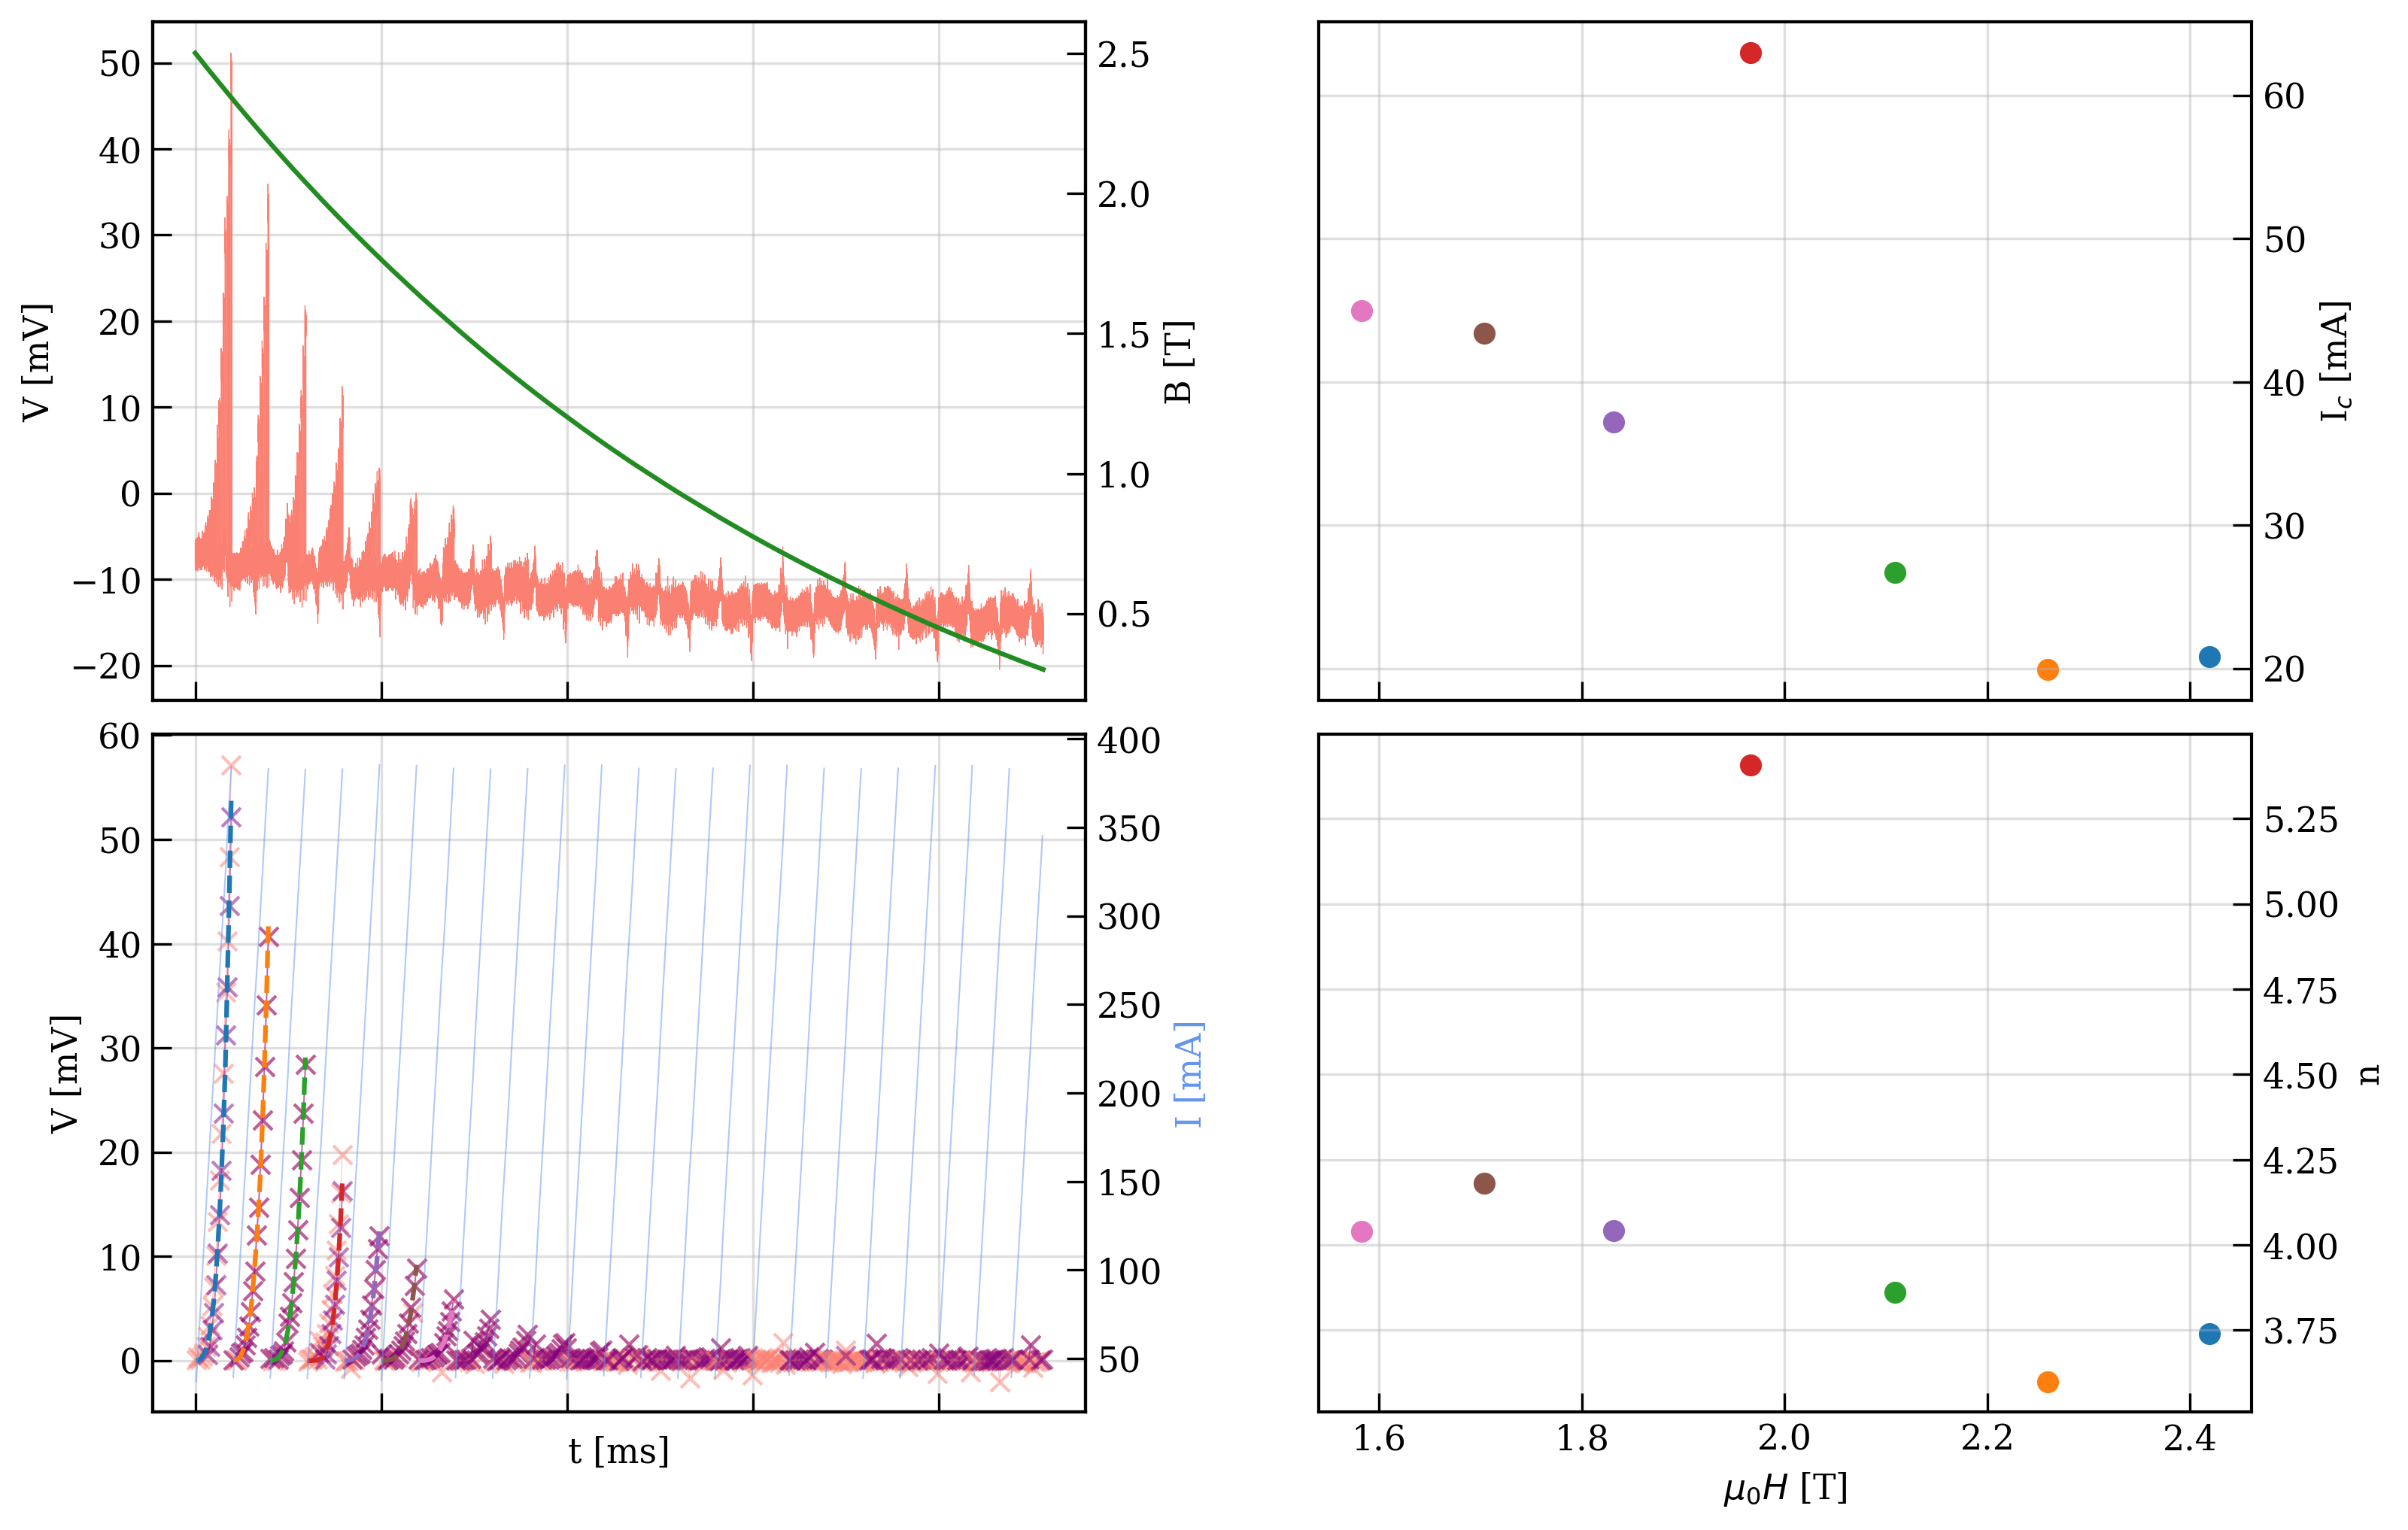

In [6]:
import os
import ipywidgets as widgets
import pathlib
from IPython.display import display, clear_output

# -----------------------------
# Saving widgets
# -----------------------------

fp = pathlib.Path(fp)
fname = fp.name
fname

savepath_w = widgets.Textarea(
    description="Save path",
    placeholder="/path/to/output/directory",
    layout=widgets.Layout(width="80%", height="60px")
)

fname_w = widgets.Text(
    description="Filename",
    placeholder="Leave empty for original",
    value = fname
)

sample_w = widgets.Text(description="Sample")
angle_w = widgets.Text(description="Angle (deg)")

save_preset_w = widgets.Dropdown(
    description="Preset",
    options=["minimal_expanded", "minimal", "full"],
    value="full"
)

verbose_w = widgets.Checkbox(
    description="Verbose",
    value=True
)
origin_w = widgets.Checkbox(
    description="Origin?",
    value=True
)

save_iv_button = widgets.Button(
    description="Save IV data",
    button_style="success"
)

save_fit_button = widgets.Button(
    description="Save fit data",
    button_style="success"
)

save_output = widgets.Output()

# -----------------------------
# Callbacks
# -----------------------------

def save_ivdata_cb(_):
    with save_output:
        clear_output()

        if "ivs" not in globals():
            print("No `ivs` object found in workspace.")
            return

        try:
            ivt.save_ivdata(
                ivs,
                fname_w.value,
                savepath_w.value,
                sample_w.value,
                angle_w.value,
                magnet_w.value,
                tfield_w.value,
                temperature_w.value,
                preset=save_preset_w.value,
                verbose=verbose_w.value
            )
            print("IV data saved successfully.")

        except Exception as e:
            print("Failed to save IV data:")
            print(e)


def save_fitdata_cb(_):
    with save_output:
        clear_output()

        if "fits" not in globals():
            print("No `fits` object found in workspace.")
            return

        try:
            ivt.save_fitdata(
                fits,
                fname_w.value,
                savepath_w.value,
                sample_w.value,
                angle_w.value,
                magnet_w.value,
                tfield_w.value,
                temperature_w.value,
                preset=save_preset_w.value,
                origin=origin_w.value,
                verbose=verbose_w.value
            )
            print("Fit data saved successfully.")

        except Exception as e:
            print("Failed to save fit data:")
            print(e)

# -----------------------------
# Wire callbacks
# -----------------------------

save_iv_button.on_click(save_ivdata_cb)
save_fit_button.on_click(save_fitdata_cb)

# -----------------------------
# Display layout
# -----------------------------

display(
    widgets.VBox([
        widgets.HTML("<b>Save results</b>"),
        savepath_w,
        fname_w,
        widgets.HBox([sample_w, angle_w]),
        widgets.HBox([save_preset_w, verbose_w, origin_w]),
        widgets.HBox([save_iv_button, save_fit_button]),
        save_output
    ])
)


NameError: name 'fp' is not defined

In [ ]:
ivf.tdms_file

In [ ]:
all_chans = {
    chan.name
    for grp in ivf.grp_names
    for chan in ivf.tdms_file[grp].channels()
}
all_chans

start_times = {}
increments = {}
dlens = {}
for grp in ivf.grp_names:
    for chan in ivf.tdms_file[grp]:
        st = ivf.tdms_file[grp][chan].properties['wf_start_time']
        inc = ivf.tdms_file[grp][chan].properties['wf_increment']
        dlen = len(ivf.tdms_file[grp][chan].data)
        start_times[chan]=st
        increments[chan]=inc
        dlens[chan]=dlen

In [ ]:
first_start = np.inf
for grp in ivf.grp_names:
    for chan in ivf.tdms_file[grp]:
        st=start_times[chan]
        # print(grp,chan,st)
        st = st.astype(np.int64)
        # print(st)
        if st<first_start:
            first_start = st
            first_start_info = [grp,chan]
print('first start:\t',first_start_info,first_start)
for grp in ivf.grp_names:
    for chan in ivf.tdms_file[grp]:
        st=start_times[chan]
        inc=increments[chan]
        dlen=dlens[chan]
        # time_array = np.timedelta64(np.arange(dlen)*inc,'s')+st
        # time_array = np.arange(dlen)*inc+np.timedelta64(st,'ns')/1e9
        time_array = np.arange(dlen)*inc + st.astype(np.int64)/1e9 - first_start/1e9
        print(grp,chan,st,)
        # print(time_array[0],time_array[-1])
        # plt.plot(np.arange(dlen),time_array)
        # print(time_array)

first start:	 ['p', 'Idot'] -2082844800010000
p Bdot 1903-12-31T23:59:59.990030
p DAQmx 6376 ai1 1903-12-31T23:59:59.990030
p Idot 1903-12-31T23:59:59.990000
p Field 1903-12-31T23:59:59.990030
p Field_fixed 1903-12-31T23:59:59.990030
i120 V 1904-01-01T00:00:00.009999
i120 I 1904-01-01T00:00:00.009999
i120 Vavg 1904-01-01T00:00:00.060262
i120 Pnum 1904-01-01T00:00:00.060262


In [ ]:
st.astype(np.int64)/1e9

np.float64(-2082844.799939738)

In [ ]:
type(st)

numpy.datetime64

In [ ]:
np.timedelta64(st)

ValueError: Could not convert object to NumPy timedelta

In [10]:
mystr = 'St.efan'
mystr = mystr.replace(".","p")
mystr

'Stpefan'